In [210]:
import datetime
import requests
import json
import pandas as pd
import numpy as np
from talib import RSI, BBANDS
import matplotlib.pyplot as plt
import psycopg2

In [212]:
def BBP(price):
    up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price['close'] - low) / (up - low)
    return bbp

In [213]:
   
r = requests.get('https://min-api.cryptocompare.com/data/histohour?fsym=APPC&tsym=BTC&limit=800&s=Binance&aggregate=1')
j = r.json()

price = pd.DataFrame(j['Data'])
price = price.iloc[::-1]
price = price.dropna()
close = price['close'].values

lastone = price.iloc[-1]

up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
rsi = RSI(close, timeperiod=14)
bbp = BBP(price)

price.insert(loc=0, column='BB_up',value=up)
price.insert(loc=0, column='BB_low',value=low)
price.insert(loc=0, column='BB_mid',value=mid)
price.insert(loc=0, column='RSI',value=rsi)
price.insert(loc=0, column='BBP',value=bbp)

holdings = pd.DataFrame(index=price.index, data={'Holdings': np.array([np.nan] * price.index.shape[0])})
holdings.loc[((price['RSI'] < 30) & (price['BBP'] < 0)), 'Holdings'] = 33
holdings.loc[((price['RSI'] > 70) & (price['BBP'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)
    
#     if(rsi.iloc[-1] > 0 and rsi.iloc[-1] < 35):
#         return {'open':lastone['open'], 'high':lastone['high'], 'low':lastone['low'], 'close':lastone['close'], 'time':lastone['time'], 'volumefrom':lastone['volumefrom'], 'volumeto':lastone['volumeto'], 'ticker':ticker, 'period':period, 'aggregate':aggregate, 'rsi':int(rsi.iloc[-1])}
                
#     return False

In [214]:
# print(holdings)

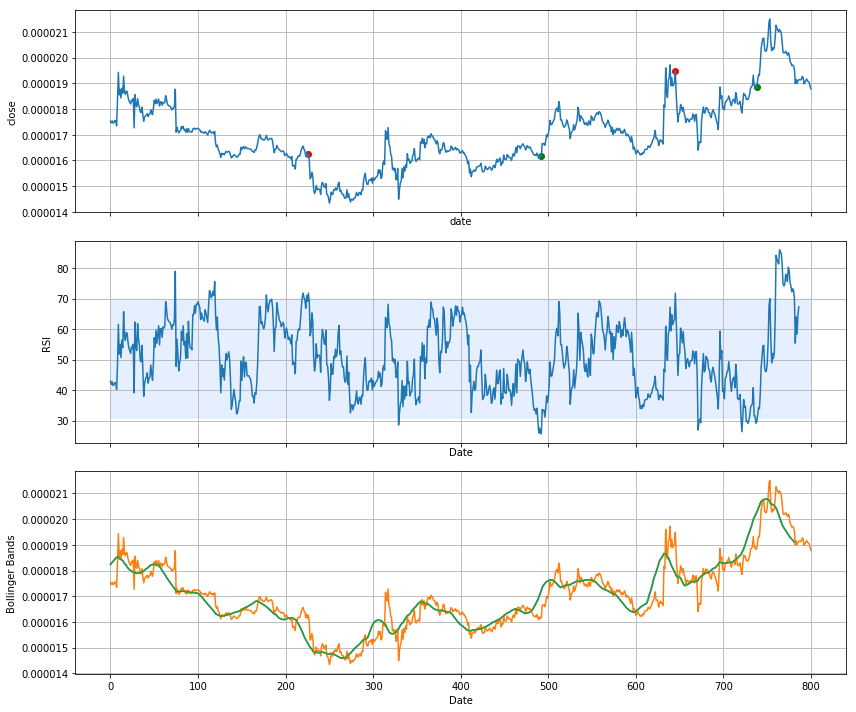

In [215]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(12, 10))
ax0.plot(price.index, price['close'], label='close')
ax0.set_xlabel('date')
ax0.set_ylabel('close')
ax0.grid()

for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=price.loc[day, 'close'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=price.loc[day, 'close'], color='red')

ax1.plot(price.index, price['RSI'], label='RSI')
ax1.fill_between(price.index, y1=31, y2=70, color='#adccff', alpha='0.3')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(price.index, price['BB_up'], label='BB_up')
ax2.plot(price.index, price['close'], label='close')
ax2.plot(price.index, price['BB_low'], label='BB_low')
ax2.fill_between(price.index, y1=price['BB_low'], y2=price['BB_up'], color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

fig.tight_layout()
plt.show()